In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Generating 1-D DCT basis


Text(0.5, 1.0, 'element: 35 from the DCT basis')

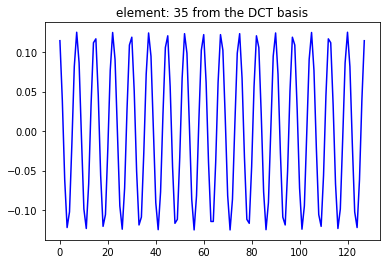

In [5]:
import numpy as np
import scipy as sp
import scipy.fftpack
from matplotlib import pyplot as plt
import scipy.io

M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = np.zeros((M, N)) # matrix containing the standard basis (a kronecker delta in each column)

# generate 1D DCT basis (DCT type II)
print('Generating 1-D DCT basis')



for k in range(M):
    # take the formula from slides and remember to normalize. Each atom goes in a column of DCT matrix
    if k == 0:
        c = np.sqrt(1/M)
    else:
        c = np.sqrt(2/M)    
    DCT[:, k] = c*np.cos(k*np.pi*(2*(np.arange(N))+1)/(2*M))
    DCT[:, k] = DCT[:,k]/np.linalg.norm(DCT[:,k],2)
    
# display an atom of the dct basis
k = 34
plt.figure(51)
plt.plot(DCT[:, k], 'b')
plt.title(f'element: {k+1} from the DCT basis')



is DCT equals to D: True
is D orth: True


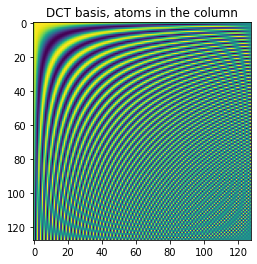

In [6]:

# display the basis in the matrix
plt.figure(3)
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')


# generate 1D DCT basis using the function idct which is the inverse dct transform stack this in the matrix D
for k in range(M):
    # define the atom
    a = np.zeros(M)
    a[k] = 1
    D[:, k] = sp.fftpack.idct(a, norm='ortho')
# display the basis in the matrix
plt.figure(3)
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')


# check that D and DCT defined above coincide
is_DCT_equal_D = np.allclose(DCT,D)
print('is DCT equals to D:',is_DCT_equal_D)


# check orthogonality
is_D_orth = np.allclose(np.eye(M),D@D.T)

print('is D orth:',is_D_orth)


Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

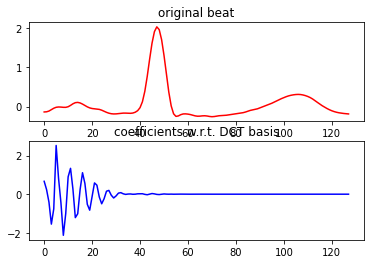

In [7]:

# Analysis: compute the representation of an input ECG signal
# load few ECG signals to be processed
temp = scipy.io.loadmat('/content/drive/MyDrive/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]
coeffD = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

# compute the representation coefficients
for i in range(nBeats):
    coeffD[:, i] = S[:,i] @ D

# display a signal and its representation coefficients
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(coeffD[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')


perfet reconstruction? True


Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

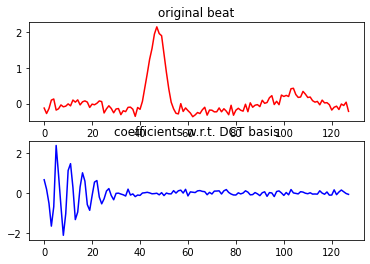

In [9]:


# Synthesis: reconstruct all the ECG signals from thei representations

# reconstruct the two signals (express them w.r.t. the standard basis)
S_hat_D = D@coeffD[:,i]

# check if there is perfect reconstruction
# trivial because S_hat_D = D * D' * S and D * D' = eye(M)  since D is orthonormal basis (the same applies to C)
is_reconstruction_perfect = np.allclose(S_hat_D,S[:,i])
print('perfet reconstruction?', is_reconstruction_perfect)



# Add noise to ECG data and inspect the representations

# ad AWGN noise to ECG signals
temp = scipy.io.loadmat('/content/drive/MyDrive/croppedECG.mat')
nBeats = 10
S0 = temp['S'][:, :nBeats]
coeffD = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

sigma_noise = 0.1
S = S0 + sigma_noise * np.random.normal(size=S0.shape)


coeffD = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

# compute the representation coefficients
for i in range(nBeats):
    coeffD[:, i] = S[:,i] @ D

# display a signal and its representation coefficients
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(coeffD[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'DCT coefficients')

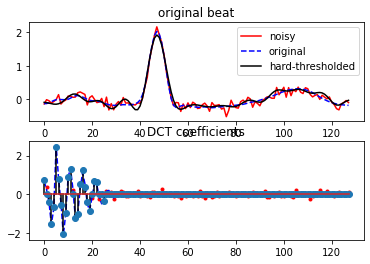

In [6]:



# Hard Thresholding
# noise affects all the coefficients of our transformation
# keep only few coefficients having largest magnitude

# ad AWGN noise to ECG signals
temp = scipy.io.loadmat('/content/drive/MyDrive/croppedECG.mat')
nBeats = 10
S0 = temp['S'][:, :nBeats]

sigma_noise = 0.1
S = S0 + sigma_noise * np.random.normal(size=S0.shape)
coeff_HT = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

S_hat = np.zeros((M, nBeats))
L = 21 # sparsity level (try different values)

for i in range(nBeats):
    origSignal = S0[:,i]
    noisySignal = S[:,i]

    # transform each signal separately (analysis)
    coeff = S[:,i] @ D

    # keep only the L largest coefficients (absolute value)
    # [...]
    ind_L_largest = np.argpartition(np.abs(coeff), -L)[-L:]

    coeff_HT[ind_L_largest, i] = coeff[ind_L_largest]

    # invert the transformation
    s_hat = D@coeff_HT[:,i]

    S_hat[:, i] = s_hat

# display a signal
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(S[:, i], 'r')
ax1.plot(S0[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.plot(np.matmul(D.T, S[:, i]), 'r.')
# coefficients of the noise free signal
ax2.plot(np.matmul(D.T, S0[:, i]), 'b--')
ax2.stem(np.arange(M), coeff_HT[:, i], 'k')
ax2.set_title('DCT coefficients')